In [1]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from pandas.core.algorithms import mode
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
# Get Ticker Data
company = "ETH-USD"

start = dt.datetime(2012, 1, 1)
end = dt.datetime.today()

data = web.DataReader(company, "yahoo", start, end)
print(data.head())

# Data Preparation
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Close"].values.reshape(-1, 1))


                High       Low      Open     Close     Volume  Adj Close
Date                                                                    
2015-08-06  3.536610  2.521120  2.831620  2.772120   164329.0   2.772120
2015-08-07  2.798810  0.714725  2.793760  0.753325   674188.0   0.753325
2015-08-08  0.879810  0.629191  0.706136  0.701897   532170.0   0.701897
2015-08-09  0.729854  0.636546  0.713989  0.708448   405283.0   0.708448
2015-08-10  1.131410  0.663235  0.708087  1.067860  1463100.0   1.067860


In [3]:
# Window Size and Data Preproccessing
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days : x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [4]:
# Building the Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))


model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=25, batch_size=32)
model.save(filepath=f"models/BTC-USD")


Epoch 1/25
69/69 [==============================] - 5s 41ms/step - loss: 0.0077
Epoch 2/25
69/69 [==============================] - 3s 41ms/step - loss: 0.0022
Epoch 3/25
69/69 [==============================] - 3s 42ms/step - loss: 0.0021
Epoch 4/25
69/69 [==============================] - 3s 45ms/step - loss: 0.0019
Epoch 5/25
69/69 [==============================] - 3s 42ms/step - loss: 0.0018
Epoch 6/25
69/69 [==============================] - 3s 42ms/step - loss: 0.0014
Epoch 7/25
69/69 [==============================] - 3s 42ms/step - loss: 0.0016
Epoch 8/25
69/69 [==============================] - 3s 42ms/step - loss: 0.0014
Epoch 9/25
69/69 [==============================] - 3s 41ms/step - loss: 0.0015
Epoch 10/25
69/69 [==============================] - 3s 41ms/step - loss: 0.0014
Epoch 11/25
69/69 [==============================] - 3s 40ms/step - loss: 0.0010
Epoch 12/25
69/69 [==============================] - 3s 40ms/step - loss: 0.0011
Epoch 13/25
69/69 [==================

INFO:tensorflow:Assets written to: models/BTC-USD\assets


INFO:tensorflow:Assets written to: models/BTC-USD\assets


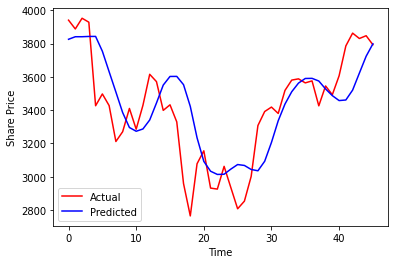

In [5]:
# Testing the accuracy using previous data
test_end = dt.datetime.today()
test_start = test_end - dt.timedelta(45)

test_data = web.DataReader(company, "yahoo", test_start, test_end)
actual_prices = test_data["Close"].values

total_dataset = pd.concat((data["Close"], test_data["Close"]), axis=0)

model_inputs = total_dataset[
    len(total_dataset) - len(test_data) - prediction_days :
].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Making Prediction
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days : x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[-1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plotting the results
plt.plot(actual_prices, color="red", label="Actual")
plt.plot(predicted_prices, color="blue", label="Predicted")
plt.xlabel("Time")
plt.ylabel("Share Price")
plt.legend()
plt.show()

61
[[3825.9363]]
[[3820.858]]
[[3797.7822]]
[[3766.7417]]
[[3733.6963]]
[[3702.0662]]
[[3673.855]]
[[3650.2341]]
[[3631.8005]]
[[3618.6824]]
[[3610.633]]
[[3607.1033]]
[[3607.3367]]
[[3610.4614]]
[[3615.572]]
[[3621.7993]]
[[3628.3667]]
[[3634.6226]]
[[3640.0698]]
[[3644.3652]]
[[3647.3203]]
[[3648.8835]]
[[3649.1196]]
[[3648.1785]]
[[3646.2751]]
[[3643.6567]]
[[3640.5745]]
[[3637.2744]]
[[3633.9712]]
[[3630.8376]]


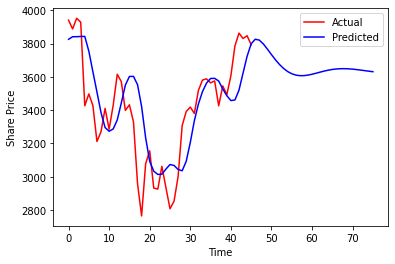

In [6]:
# Predicting future stock prices
prediction_dataset = total_dataset[-prediction_days - 1:].values
print(len(prediction_dataset))
predicted_values = []

for i in range(1, 31):
    model_inputs = prediction_dataset.reshape(-1, 1)
    model_inputs = scaler.transform(model_inputs)

    real_data = [
        model_inputs[-prediction_days : len(model_inputs) + 1, 0]
    ]
    real_data = np.array(real_data)
    real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
    prediction = model.predict(real_data)
    prediction = scaler.inverse_transform(prediction)
    
    print(prediction)
    predicted_values.append(float(prediction))
    prediction_dataset = np.append(prediction_dataset, float(prediction))

predicted_graph = [float(i) for i in predicted_prices] + predicted_values
plt.plot(actual_prices, color="red", label="Actual")
plt.plot(predicted_graph, color="blue", label="Predicted")
plt.xlabel("Time")
plt.ylabel("Share Price")
plt.legend()
plt.show()

